# Supervised Learning: Regression

[Regression](https://en.wikipedia.org/wiki/Regression_analysis) analysis is a statistical process for estimating the relationships between two or more variables. The relationship is modeled as 

$$y \sim x$$
or 
$$y = f(x)\text{.}$$

Both model descriptions indicate  that the variable $y$ is a function  of $x$. Therefore the variable $y$ is denoted as **response variable** or **dependent variable**, whereas the variable $x$ is denoted as **predictor variable** or **independent variable**. 

The function $f(x;\beta)$ is called a **regression function** and $\beta$ are its free parameters.


<img src="https://imgs.xkcd.com/comics/extrapolating.png", width = "500px">

Source: [xkcd](https://xkcd.com/605/)

**Import libraries**

In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## The machine learning model development process

<img src="./_img/ML_scheme.png", style="height: 600px;">

## Data preparation

In this section we work with the *trees* data set, a data set that ships with the [R-package `datasets`](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/trees.html) (Ryan et al. 1976). The *trees* data set provides measurements of the girth, height and volume of timber in 31 felled black cherry trees, also known as [*Prunus serotina*](https://en.wikipedia.org/wiki/Prunus_serotina). The height of the trees is given in feet (ft) and the volume is given in in cubic feet (cft). The girth is the diameter of the tree (in inches) measured at 4 ft 6 in (approx. 1.37 m) above the ground.  

We load the data set using pandas `read_csv` and take a quick look at the data set by applying the `head` function.

In [14]:
trees_raw = pd.read_csv("../datasets/trees.csv", index_col=0)
print(trees_raw.shape)
trees_raw.head()

(31, 3)


,Girth,Height,Volume
1,8.3,70,10.3
2,8.6,65,10.3
3,8.8,63,10.2
4,10.5,72,16.4
5,10.7,81,18.8


For a better understanding we convert the variables in meters, respectively, cubic meters, by applying these equations 

$$ 1\; \text{in} = 0.0254\;\text{m,}$$

$$ 1\; \text{ft} = 0.3048\;\text{m,}$$

and

$$ 1\; \text{cft} = 0.0283168\;\text{m}^3\text{.}$$

> __Challenge: Convert the feature `Girth`,`Height` and `Volume` from inches, feet and cubic feet into meters and cubic meters.__

In [15]:
%%writefile ../src/_solutions/convert2meters.py
def convert2meter(s, input_unit="in"):
    '''
    Function to convert inches, feet and cubic feet to meters and cubic meters 
    '''
    if input_unit == "in":
        return s*0.0254
    elif input_unit == "ft":
        return s*0.3048
    elif input_unit == "cft":
        return s*0.0283168
    else:
        print("Error: Input unit is unknown.")

Overwriting ../src/_solutions/convert2meters.py


In [16]:
# %load ../src/_solutions/convert2meters.py
def convert2meter(s, input_unit="in"):
    '''
    Function to convert inches, feet and cubic feet to meters and cubic meters 
    '''
    if input_unit == "in":
        return s*0.0254
    elif input_unit == "ft":
        return s*0.3048
    elif input_unit == "cft":
        return s*0.0283168
    else:
        print("Error: Input unit is unknown.")

In [17]:
## Apply function
measurement_unit = {"Girth":"in",
                    "Height":"ft", 
                    "Volume":"cft"}

trees = trees_raw.copy()
for feature in ["Girth", "Height", "Volume"]:
    trees[feature] = trees_raw[feature].apply(lambda x: convert2meter(s=x,
                                                                input_unit=measurement_unit.get(feature))) 

In [18]:
trees.head()

,Girth,Height,Volume
1,0.21082,21.3360,0.291663
2,0.21844,19.8120,0.291663
3,0.22352,19.2024,0.288831
4,0.26670,21.9456,0.464396
5,0.27178,24.6888,0.532356


It is always a good idea to visualize the data we want a work with. However, instead of a scatter plot, which is fine for the comparison of two variables, we are going to plot a scatter plot matrix to account for multiple variables. The `seaborn` library provides the handy `pairplot` function for plotting scatter plot matrices.  

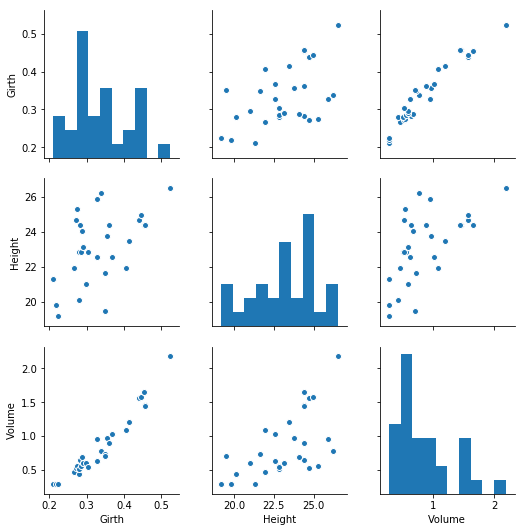

In [19]:
sns.pairplot(trees);


A quick visual inspection indicates that there is an approximately linear relationship between girth and to somehow a less pronounced linear relationship between height and volume. Any relation between height and girth is less obvious. 

> The goal in this example is to build a linear regression model with `Volume` being the dependent variable and `Height` and `Girth` being the independent (explanatory) variables.


## Train-(Validation)-Test-Split

In [20]:
%%writefile ../src/_solutions/train_validation_test.py
def train_test_split(df, ratio=0.3, rs=42):
    np.random.seed(rs)
    idx = np.random.choice([True, False], size=df.shape[0], 
                           replace=True, p=[1-ratio, ratio])
    train = df.loc[idx,:]
    test = df.loc[~idx,:]
    print("Train set: {}".format(train.shape))
    print("Test set: {}".format(test.shape))
    return train, test

Overwriting ../src/_solutions/train_validation_test.py


In [21]:
# %load ../src/_solutions/train_validation_test.py
def train_test_split(df, ratio=0.3, rs=42):
    np.random.seed(rs)
    idx = np.random.choice([True, False], size=df.shape[0], 
                           replace=True, p=[1-ratio, ratio])
    train = df.loc[idx,:]
    test = df.loc[~idx,:]
    print("Train set: {}".format(train.shape))
    print("Test set: {}".format(test.shape))
    return train, test    

In [22]:
train, test = train_test_split(trees, ratio=0.4, rs=42)   

Train set: (21, 3)
Test set: (10, 3)


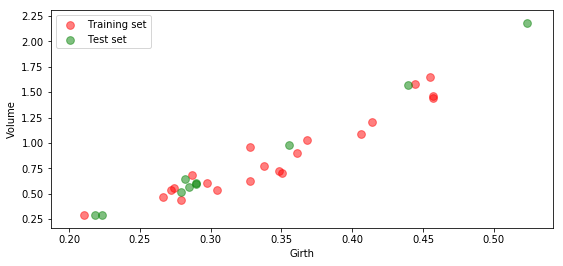

In [23]:
fig, ax = plt.subplots(figsize=(9,4))
train.plot.scatter(x="Girth", y="Volume", ax=ax, 
                   alpha=0.5, s=60, color="r", label="Training set")
test.plot.scatter(x="Girth", y="Volume", ax=ax, 
                  alpha=0.5, s=60, color="g", label="Test set");

## Learning Algorithm

### Hypothesis and Model Parameters

#### Simple Linear Regression 


In [**linear regression**](https://en.wikipedia.org/wiki/Simple_linear_regression) models a relationship between the response variable $y$ and and the predictor variable $x$ is given in form of a **linear** equation

$$y = \beta_0 + \beta_1 x + \epsilon$$

where $\beta_0$ and $\beta_1$ are constants and $\epsilon$ is a **random error term** added to the linear model equation, thus resulting in a probabilistic model. The number $\beta_0$ is called **intercept**, sometimes referred to as *bias, shift* or *offset*, and defines the point of intersection of the line  and the $y$-axis $(x=0)$. The number $\beta_1$ is called **regression coefficient**. It is a measure of the slope of the **regression line**. Thus, $\beta_1$ indicates how much the $y$-value changes when the $x$-value increases by 1 unit. The error term $\epsilon_i$, sometimes referred to as *residuals*,  is assumed to consist of independent normal distributed values, $e_i \sim N(0, \sigma^2)$.



![Linear Model](./_img/lm1.png)


The error $\epsilon_i$ for each particular pair of values ($x_i,y_i$) is computed by the difference of the observed value $y_i$ and the predicted value given by $\hat y_i$.

$$\epsilon_i = y_i - \hat y_i$$

Depending on the data $\epsilon_i$ is a negative number if $y_i$ plots below the regression line or it is a positive number if $y_i$ plots above the regression line.



#### Multiple Linear Regression 

A [multiple linear regression](https://en.wikipedia.org/wiki/Regression_analysis) model is a generalization of the simple linear regression model.


By extending the equation $y = \beta_0 + \beta_1 x + \epsilon$ to a set of $n$ observations and $d$ explanatory variables, $x_1,\cdots, x_d$ the regression model can be written as 

$$
\begin{align}
y_i & = \beta_0 + \sum_{j=1}^dx_{ij}\beta_j + \epsilon_i \\
& = \beta_0 + \beta_1x_{1i} + \beta_2x_{2i} +\cdots + \beta_dx_{di} + \epsilon_i \text{.} 
\quad i = 1,2,\dots n\text{, } x\in \mathbb R^d\text{.}
\end{align}
$$

#### Matrix Notation

A regression model based upon $n$ observations (measurements) consists of of $n$ response variables, $y_1, y_2,...y_n$. For the ease of notation we write the response variables as a one-dimensional column vector of the size $y_{n \times 1}$.

$$
\begin{align}
\mathbf y_{n \times 1}=  
       \begin{bmatrix}
        y_{1} \\
        y_{2} \\
        \vdots \\
        y_{n} \\
        \end{bmatrix}
\end{align}
$$

Moreover, for each particular observation $x_i$ $(x_1, x_2,..., x_n)$ we represent the associated explanatory variables $d$ as a column vector as well.

$$
\begin{align}
\mathbf x_{i}=  
       \begin{bmatrix}
        x_{i1} \\
        x_{i2} \\
        \vdots \\
        x_{id} \\
        \end{bmatrix}
\end{align}
\text{(e.g.)}  \Rightarrow          
  \begin{bmatrix}
  \text{height} \\
  \text{weight} \\
  \vdots \\
  \text{age} \\
  \end{bmatrix}
$$

Further, by transposing $x_i$ we stack a set of $n$ observation vectors into a matrix $X$ of the form $x_{n \times d}$:

$$
\begin{align}
 \mathbf X_{n \times d}= 
        \begin{bmatrix}
        -x_{1}^T - \\
        -x_{2}^T -\\
        \vdots \\
        -x_{n1}-\\
        \end{bmatrix}
        = 
       \begin{bmatrix}
        x_{11} & x_{12} & \cdots & x_{1d} \\
        x_{21} & x_{22} & \cdots & x_{2d} \\
        \vdots & \vdots & \ddots & \vdots \\
        x_{n1} & x_{n2} & \cdots & x_{nd} \\
        \end{bmatrix}
\end{align}
$$

This matrix notation is very similar to a spreadsheet representation, where each row corresponds to an observation and each column to a feature. Please note that we assume that all features are continuous-valued $(x \in \mathbb R^d)$ and that there are more observations than dimensions $(n > d)$. 


For linear regression (and classification) the intercept term $\beta_0$ does not interact with any element in the vector $x \in \mathbb R^d$. Thus it is convenient to populate the first column of the matrix $\mathbf X$ with ones:

$$
\begin{align}
 \mathbf X_{n \times d+1}= 
       \begin{bmatrix}
        1 & x_{11} & x_{12} & \cdots & x_{1d} \\
        1 &x_{21} & x_{22} & \cdots & x_{2d} \\
        \vdots &\vdots & \vdots & \ddots & \vdots \\
        1 & x_{n1} & x_{n2} & \cdots & x_{nd} \\
        \end{bmatrix}
\end{align}
$$

Note that the matrix $\mathbf X$ is now of the size $n \times d+1$ and that $\beta\in \mathbb R^{d+1}$, and thus $[\beta_0, \beta_1,...,\beta_d]^T$ is of size $d+1 \times 1$. The vector $\mathbf y$ is denoted as **target vector** and the matrix $\mathbf X$ is called the **feature matrix**. 

$$
\begin{align}
\mathbf y_{n \times 1}=  
       \begin{bmatrix}
        y_{1} \\
        y_{2} \\
        \vdots \\
        y_{n} \\
        \end{bmatrix}\text{,}
\quad
\mathbf \beta_{d+1 \times 1}^T= 
       \begin{bmatrix}
        \beta_0 \\
        \beta_1 \\
        \vdots \\
        \beta_d  \\
        \end{bmatrix}
\end{align}
$$


Recalling the basics of [**Linear Algebra**](https://en.wikipedia.org/wiki/Linear_algebra), we know that the [*dot product*](https://en.wikipedia.org/wiki/Dot_product), also referred to as the *scalar product* of a vector $\mathbf u_{1\times n}$ with a vector $\mathbf v_{n\times 1}$ results in a scalar $w$ ($w$ may be written as a matrix of size $1\times1$). The value of the scalar $w$ corresponds to the sum of the products of the elements in the vectors $\mathbf u$ and $\mathbf v$.

$$\mathbf u \cdot \mathbf v = \sum_{i=1}^n  u_1v_1+u_2v_2+...+ u_nv_n$$

![Data Layout](./_img/data-layout.png)




### Objective function (The loss function)

Recall the equation for the multiple regression model

$$
y_i = \beta_0 + \sum_{j=1}^dx_{ij}\beta_j + \epsilon_i  \text{,} 
\quad i = 1,2,...n\text{, } x\in \mathbb R^d
$$

In order to find a appropriate set of parameters $\beta$ we need to define an [**objective function**](https://en.wikipedia.org/wiki/Mathematical_optimization) $(\mathcal L)$. 

One of the the most popular estimation method is the so-called [ordinary least squares (OSL) method](https://en.wikipedia.org/wiki/Ordinary_least_squares). Thereby the coefficients $\beta_0, \beta_1,\beta_2,...,\beta_{d}$ are picked by minimizing the residual sum of squares. 

$$\mathcal L = \sum_{i=1}^n\epsilon_i^2=\sum_{i=1}^n(y_i - f(x_i; \beta))^2$$


By plugging in the regression model equation from above we get 


$$\mathcal L = \sum_{i=1}^n(y_i - \beta_0 + \sum_{j=1}^dx_{ij}\beta_j)^2\text{,}$$
where $n$ corresponds to the number of observations and $d$ corresponds to the number of features of our data set.


> __Challenge: Use the *trees* data set to construct the target vector, `y` and the feature matrix, `X`.__

In [24]:
%%writefile ../src/_solutions/model_matrix.py
def model_matrix(data, y_col, x_col):
    if not isinstance(x_col, list):
        x_col = [x_col]
        
    # target vector shape (31,1)
    y = data[y_col].values.reshape(-1,1)
    print("Target vector y: {}".format(y.shape))

    # feature matrix shape (31,3)
    X = data.copy()
    X["beta0"]= 1
    X = X[["beta0"]+x_col].values
    print("Feature matrix X: {}".format(X.shape))    
    return X, y

Overwriting ../src/_solutions/model_matrix.py


In [25]:
# %load ../src/_solutions/model_matrix.py
def model_matrix(data, y_col, x_col):
    if not isinstance(x_col, list):
        x_col = [x_col]
        
    # target vector shape (31,1)
    y = data[y_col].values.reshape(-1,1)
    print("Target vector y: {}".format(y.shape))

    # feature matrix shape (31,3)
    X = data.copy()
    X["beta0"]= 1
    X = X[["beta0"]+x_col].values
    print("Feature matrix X: {}".format(X.shape))    
    return X, y

In [26]:
X_train, y_train = model_matrix(train, 
                                y_col="Volume", 
                                x_col=["Height", "Girth"])

X_test, y_test = model_matrix(test, 
                              y_col="Volume", 
                              x_col=["Height", "Girth"])

Target vector y: (21, 1)
Feature matrix X: (21, 3)
Target vector y: (10, 1)
Feature matrix X: (10, 3)


#### Optimization


Returning to our problem we see that we may rewrite the original least squares objective function

$$\mathcal L = \sum_{i=1}^n(y_i - \beta_0 + \sum_{j=1}^dx_{ij}\beta_j)^2\text{,}$$

by using the matrix notation as 


$$\mathcal L = \sum_{i=1}^n(y_i - x_i^T \beta)^2$$

The representation in matrix form allows us to further simplify the equation by plugging in the response vector $\mathbf y$ and the model matrix $\mathbf X$:


$$\mathcal L = \sum_{i=1}^n(y_i - x_i^T \beta)^2 = \Vert\mathbf y - \mathbf X\beta\Vert^2 = (\mathbf y - \mathbf X\beta)^T(\mathbf y - \mathbf X\beta)$$
Now, in order to find the least squares solution we take the gradient with respect to $\beta$ and find a unique solution $\hat \beta$:

$$\nabla_\beta\mathcal L=2\mathbf X^T\mathbf X \beta-2\mathbf X^T\mathbf y \quad \Rightarrow \quad\hat \beta =  (\mathbf X^T\mathbf X)^{-1}\mathbf X^T\mathbf y$$





In [27]:
%%writefile ../src/_solutions/one_step_learning.py
def one_step_learning(X, y):
    return np.dot( np.dot ( np.linalg.inv ( np.dot(X.T, X) ), X.T), y )

Overwriting ../src/_solutions/one_step_learning.py


In [28]:
# %load ../src/_solutions/one_step_learning.py
def one_step_learning(X, y):
    return np.dot( np.dot ( np.linalg.inv ( np.dot(X.T, X) ), X.T), y )

In [29]:
beta_hat = one_step_learning(X_train, y_train)
beta_hat

array([[-1.70232819],
       [ 0.03563765],
       [ 5.05446596]])

$$ y = \beta_0 + \beta_1x + \beta_2x $$

$$ \text{Volume} = -1.70 + 0.04 \times \text{Height} + 5.05 \times \text{Girth}$$

#### Predictions

Given new data $\mathbf X_{new}$, the least squares prediction for $\hat y$ is

$$\hat y = \mathbf X_{new}\hat \beta = \mathbf X_{new}(\mathbf X^T\mathbf X)^{-1}\mathbf X^T\mathbf y$$


Be aware that the calculation of $\hat \beta = (\mathbf X^T\mathbf X)^{-1}\mathbf X^T\mathbf y$ assumes $(\mathbf X^T\mathbf X)^{-1}$ exists. Therefore $\mathbf X^T\mathbf X$ has to be a full rank matrix. A matrix is full rank when the $n \times (d + 1)$ matrix $\mathbf X$ has at least $d + 1$ linearly independent rows. This means that any point in $\mathbb R^{d+1}$ can be reached by a weighted combination of $d + 1$ rows of $\mathbf X$. Thus, if $n < d + 1$ least squares fails as if $(\mathbf X^T\mathbf X)^{-1}$ does not exist, as there are an infinite number of possible solutions.


In [30]:
%%writefile ../src/_solutions/predict.py
def predict(X, beta):
    return np.dot(X, beta)

Overwriting ../src/_solutions/predict.py


In [31]:
# %load ../src/_solutions/predict.py
def predict(X, beta):
    return np.dot(X, beta)

In [32]:
h=22
g=1.2
predict(np.array([1, h, g]), beta_hat)

array([5.14705932])

In [42]:
XX = trees.sample(8, random_state=42).copy().reset_index(drop=True)
XX

,Girth,Height,Volume
0,0.45466,24.3840,1.650869
1,0.32766,22.5552,0.628633
2,0.40640,21.9456,1.084533
3,0.33782,26.2128,0.775880
4,0.28194,24.3840,0.639960
5,0.28448,22.8600,0.563504
6,0.45720,24.3840,1.444157
7,0.41402,23.4696,1.206296


In [43]:
prediction_set, _ = model_matrix(XX, "Volume", ["Height", "Girth"])
prediction_set

Target vector y: (8, 1)
Feature matrix X: (8, 3)


array([[ 1.     , 24.384  ,  0.45466],
       [ 1.     , 22.5552 ,  0.32766],
       [ 1.     , 21.9456 ,  0.4064 ],
       [ 1.     , 26.2128 ,  0.33782],
       [ 1.     , 24.384  ,  0.28194],
       [ 1.     , 22.86   ,  0.28448],
       [ 1.     , 24.384  ,  0.4572 ],
       [ 1.     , 23.4696 ,  0.41402]])

In [44]:
XX.loc[:,"Predicted Volume"] = pd.Series(predict(prediction_set, beta_hat).ravel())
XX

,Girth,Height,Volume,Predicted Volume
0,0.45466,24.3840,1.650869,1.464724
1,0.32766,22.5552,0.628633,0.757633
2,0.40640,21.9456,1.084533,1.133896
3,0.33782,26.2128,0.775880,0.939334
4,0.28194,24.3840,0.639960,0.591716
5,0.28448,22.8600,0.563504,0.550243
6,0.45720,24.3840,1.444157,1.477562
7,0.41402,23.4696,1.206296,1.226723


**Predictions on the test set, the so far not seen data** 

In [45]:
predictions = predict(X_test, beta_hat)
predictions

array([[0.10782253],
       [0.1117745 ],
       [0.52456634],
       [0.59171647],
       [0.55024303],
       [0.58678207],
       [0.58678207],
       [0.94230372],
       [1.39855612],
       [1.8873956 ]])

### Evaluation metric

Recall that out optimization approach is based on minimizing the **sum of squared errors (SSE)**:


$$SSE = \sum e^2 = \sum (\hat y - y)^2\text{.}$$


A widely applied metric to evaluate the goodness-of-fit of the model is the [**root-mean-square error (RMSE)**](https://en.wikipedia.org/wiki/Root-mean-square_deviation) defined by

$$RMSE = \sqrt{\frac{\sum_{i=1}^n (\hat y - y)^2}{n}}\text{.}$$


In [46]:
%%writefile ../src/_solutions/rmse.py
def rmse(y_hat, y):
    return np.sqrt(np.sum((y_hat-y)**2)/len(y))

Overwriting ../src/_solutions/rmse.py


In [47]:
# %load ../src/_solutions/rmse.py
def rmse(y_hat, y):
    return np.sqrt(np.sum((y_hat-y)**2)/len(y))

In [48]:
rmse(predictions, y_test)

0.13571214114325134

***
$
\begin{array}{lll}
\text{Summary} & \\
\hline
\text{Hypothesis} & \text{Linear model} & \bf{\hat y} = \bf x^T \beta \\
\text{Model parameters} & \beta_0, \beta_1, \beta_2 &\\
\text{Hyperparameters} & \text{None}  &\\
\text{Objective function} & \text{Sum of squared errors (SSE)} & \sum (\hat y - y)^2 \\
\text{Optimization} & \text{One step learning (analytic approach)} & \hat \beta =  (\mathbf X^T\mathbf X)^{-1}\mathbf X^T\mathbf y \\
\text{Evaluation metric} & \text{Root mean square error (RMSE)} &\sqrt{\frac{\sum_{i=1}^n (\hat y - y)^2}{n}} \\
\hline
\end{array}
$
